In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
import optuna
import warnings
warnings.filterwarnings("ignore")
import shap

ModuleNotFoundError: No module named 'optuna'

In [2]:
# Normalized, one-hot-encoded, and feature-engineered dataset
data = pd.read_csv('final_processed_data.csv')

In [3]:
# Splitting features and target variable
X = data.drop("popularity", axis=1)   # features
y = data["popularity"]               # target

In [4]:
print(X.columns)

Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'playlist_count', 'genre_edm', 'genre_latin',
       'genre_pop', 'genre_r&b', 'genre_rap', 'genre_rock',
       'subgenre_album rock', 'subgenre_big room', 'subgenre_classic rock',
       'subgenre_dance pop', 'subgenre_electro house', 'subgenre_electropop',
       'subgenre_gangster rap', 'subgenre_hard rock', 'subgenre_hip hop',
       'subgenre_hip pop', 'subgenre_indie poptimism',
       'subgenre_latin hip hop', 'subgenre_latin pop', 'subgenre_neo soul',
       'subgenre_new jack swing', 'subgenre_permanent wave',
       'subgenre_pop edm', 'subgenre_post-teen pop',
       'subgenre_progressive electro house', 'subgenre_reggaeton',
       'subgenre_southern hip hop', 'subgenre_trap', 'subgenre_tropical',
       'subgenre_urban contemporary', 'artist_avg_popularity',
       'artist_song_count', 'artist_high_pop_ratio',

In [5]:
# Split the dataset into training(%80) and test(%20) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(22684, 57) (5672, 57)


In [6]:
y_train_pred_mean = [y_train.mean()] * len(y_train)
y_test_pred_mean  = [y_train.mean()] * len(y_test)

print("BASELINE (train): MAE, RMSE, R2 =",
      mean_absolute_error(y_train, y_train_pred_mean),
      np.sqrt(mean_squared_error(y_train, y_train_pred_mean)),
      r2_score(y_train, y_train_pred_mean))

print("BASELINE (test): MAE, RMSE, R2 =",
      mean_absolute_error(y_test, y_test_pred_mean),
      np.sqrt(mean_squared_error(y_test, y_test_pred_mean)),
      r2_score(y_test, y_test_pred_mean))


BASELINE (train): MAE, RMSE, R2 = 19.8936972829277 23.690550511863467 0.0
BASELINE (test): MAE, RMSE, R2 = 19.914148711219504 23.747533757202742 -3.851367790019822e-06


In [7]:
# Base Random Forest model evaluation with cross-validation
rf_base = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

scores = cross_val_score(
    rf_base,
    X_train, y_train,
    cv=5,
    scoring="neg_mean_absolute_error"
)

print("Base RF CV MAE:", -scores.mean())
print("STD:", scores.std())

Base RF CV MAE: 10.588002260524666
STD: 0.07964700644112216


In [8]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        "max_depth": trial.suggest_int("max_depth", 5, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 40),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", 0.3, 0.5, 0.7]),
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestRegressor(**params)

    score = cross_val_score(
        model,
        X_train,
        y_train,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1
    ).mean()

    return -score   # MAE minimize edildiği için


In [9]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60, show_progress_bar=True)


[I 2025-12-02 22:03:53,168] A new study created in memory with name: no-name-31c58a49-ed63-4e31-b71a-d37b6f409d58
Best trial: 0. Best value: 10.9028:   2%|▏         | 1/60 [00:15<14:45, 15.01s/it]

[I 2025-12-02 22:04:08,183] Trial 0 finished with value: 10.902811785400626 and parameters: {'n_estimators': 485, 'max_depth': 8, 'min_samples_split': 31, 'min_samples_leaf': 9, 'max_features': 0.3}. Best is trial 0 with value: 10.902811785400626.


Best trial: 1. Best value: 10.3086:   3%|▎         | 2/60 [01:44<56:39, 58.61s/it]

[I 2025-12-02 22:05:37,310] Trial 1 finished with value: 10.308590820845096 and parameters: {'n_estimators': 773, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.7}. Best is trial 1 with value: 10.308590820845096.


Best trial: 1. Best value: 10.3086:   5%|▌         | 3/60 [02:07<40:21, 42.49s/it]

[I 2025-12-02 22:06:00,611] Trial 2 finished with value: 10.687238774287609 and parameters: {'n_estimators': 654, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 0.3}. Best is trial 1 with value: 10.308590820845096.


Best trial: 1. Best value: 10.3086:   7%|▋         | 4/60 [02:32<33:14, 35.61s/it]

[I 2025-12-02 22:06:25,683] Trial 3 finished with value: 10.320204095923476 and parameters: {'n_estimators': 444, 'max_depth': 25, 'min_samples_split': 32, 'min_samples_leaf': 6, 'max_features': 0.3}. Best is trial 1 with value: 10.308590820845096.


Best trial: 1. Best value: 10.3086:   8%|▊         | 5/60 [02:40<23:39, 25.81s/it]

[I 2025-12-02 22:06:34,100] Trial 4 finished with value: 12.246153864380261 and parameters: {'n_estimators': 513, 'max_depth': 11, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 10.308590820845096.


Best trial: 1. Best value: 10.3086:  10%|█         | 6/60 [03:03<22:10, 24.64s/it]

[I 2025-12-02 22:06:56,468] Trial 5 finished with value: 11.33789295915128 and parameters: {'n_estimators': 794, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 10.308590820845096.


Best trial: 1. Best value: 10.3086:  12%|█▏        | 7/60 [03:24<20:51, 23.61s/it]

[I 2025-12-02 22:07:17,972] Trial 6 finished with value: 10.361655595472287 and parameters: {'n_estimators': 522, 'max_depth': 13, 'min_samples_split': 32, 'min_samples_leaf': 8, 'max_features': 0.3}. Best is trial 1 with value: 10.308590820845096.


Best trial: 7. Best value: 10.1472:  13%|█▎        | 8/60 [03:54<22:09, 25.57s/it]

[I 2025-12-02 22:07:47,739] Trial 7 finished with value: 10.147169428372527 and parameters: {'n_estimators': 364, 'max_depth': 11, 'min_samples_split': 26, 'min_samples_leaf': 2, 'max_features': 0.7}. Best is trial 7 with value: 10.147169428372527.


Best trial: 7. Best value: 10.1472:  15%|█▌        | 9/60 [04:18<21:23, 25.18s/it]

[I 2025-12-02 22:08:12,047] Trial 8 finished with value: 10.311601402660752 and parameters: {'n_estimators': 665, 'max_depth': 22, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 0.3}. Best is trial 7 with value: 10.147169428372527.


Best trial: 7. Best value: 10.1472:  17%|█▋        | 10/60 [05:02<25:37, 30.74s/it]

[I 2025-12-02 22:08:55,251] Trial 9 finished with value: 10.21012767308638 and parameters: {'n_estimators': 783, 'max_depth': 21, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 7 with value: 10.147169428372527.


Best trial: 7. Best value: 10.1472:  18%|█▊        | 11/60 [05:10<19:27, 23.84s/it]

[I 2025-12-02 22:09:03,430] Trial 10 finished with value: 10.431194008019268 and parameters: {'n_estimators': 304, 'max_depth': 5, 'min_samples_split': 25, 'min_samples_leaf': 3, 'max_features': 0.7}. Best is trial 7 with value: 10.147169428372527.


Best trial: 7. Best value: 10.1472:  20%|██        | 12/60 [05:52<23:29, 29.36s/it]

[I 2025-12-02 22:09:45,420] Trial 11 finished with value: 10.178059628375216 and parameters: {'n_estimators': 867, 'max_depth': 17, 'min_samples_split': 40, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 7 with value: 10.147169428372527.


Best trial: 7. Best value: 10.1472:  22%|██▏       | 13/60 [06:07<19:40, 25.12s/it]

[I 2025-12-02 22:10:00,781] Trial 12 finished with value: 10.192015915446525 and parameters: {'n_estimators': 300, 'max_depth': 16, 'min_samples_split': 39, 'min_samples_leaf': 3, 'max_features': 0.5}. Best is trial 7 with value: 10.147169428372527.


Best trial: 7. Best value: 10.1472:  23%|██▎       | 14/60 [06:50<23:16, 30.37s/it]

[I 2025-12-02 22:10:43,273] Trial 13 finished with value: 10.182573739887518 and parameters: {'n_estimators': 859, 'max_depth': 18, 'min_samples_split': 38, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 7 with value: 10.147169428372527.


Best trial: 7. Best value: 10.1472:  25%|██▌       | 15/60 [07:17<22:01, 29.36s/it]

[I 2025-12-02 22:11:10,291] Trial 14 finished with value: 10.179708449283694 and parameters: {'n_estimators': 400, 'max_depth': 14, 'min_samples_split': 27, 'min_samples_leaf': 3, 'max_features': 0.7}. Best is trial 7 with value: 10.147169428372527.


Best trial: 7. Best value: 10.1472:  27%|██▋       | 16/60 [07:51<22:32, 30.74s/it]

[I 2025-12-02 22:11:44,257] Trial 15 finished with value: 10.208574038268699 and parameters: {'n_estimators': 606, 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 7 with value: 10.147169428372527.


Best trial: 16. Best value: 10.1441:  28%|██▊       | 17/60 [08:43<26:42, 37.26s/it]

[I 2025-12-02 22:12:36,657] Trial 16 finished with value: 10.144127593000016 and parameters: {'n_estimators': 896, 'max_depth': 12, 'min_samples_split': 40, 'min_samples_leaf': 10, 'max_features': 0.7}. Best is trial 16 with value: 10.144127593000016.


Best trial: 16. Best value: 10.1441:  30%|███       | 18/60 [09:05<22:52, 32.68s/it]

[I 2025-12-02 22:12:58,679] Trial 17 finished with value: 10.146890022017978 and parameters: {'n_estimators': 374, 'max_depth': 11, 'min_samples_split': 26, 'min_samples_leaf': 2, 'max_features': 0.7}. Best is trial 16 with value: 10.144127593000016.


Best trial: 16. Best value: 10.1441:  32%|███▏      | 19/60 [09:25<19:44, 28.90s/it]

[I 2025-12-02 22:13:18,766] Trial 18 finished with value: 10.43435889997449 and parameters: {'n_estimators': 721, 'max_depth': 5, 'min_samples_split': 35, 'min_samples_leaf': 10, 'max_features': 0.7}. Best is trial 16 with value: 10.144127593000016.


Best trial: 16. Best value: 10.1441:  33%|███▎      | 20/60 [10:00<20:28, 30.72s/it]

[I 2025-12-02 22:13:53,726] Trial 19 finished with value: 10.150122766143488 and parameters: {'n_estimators': 559, 'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 0.7}. Best is trial 16 with value: 10.144127593000016.


Best trial: 20. Best value: 10.1319:  35%|███▌      | 21/60 [10:20<17:46, 27.35s/it]

[I 2025-12-02 22:14:13,224] Trial 20 finished with value: 10.131872413250779 and parameters: {'n_estimators': 436, 'max_depth': 8, 'min_samples_split': 23, 'min_samples_leaf': 10, 'max_features': 0.7}. Best is trial 20 with value: 10.131872413250779.


Best trial: 21. Best value: 10.131:  37%|███▋      | 22/60 [10:36<15:19, 24.20s/it] 

[I 2025-12-02 22:14:30,074] Trial 21 finished with value: 10.131007133988408 and parameters: {'n_estimators': 384, 'max_depth': 8, 'min_samples_split': 23, 'min_samples_leaf': 10, 'max_features': 0.7}. Best is trial 21 with value: 10.131007133988408.


Best trial: 21. Best value: 10.131:  38%|███▊      | 23/60 [10:55<13:58, 22.66s/it]

[I 2025-12-02 22:14:49,131] Trial 22 finished with value: 10.131974089102936 and parameters: {'n_estimators': 431, 'max_depth': 8, 'min_samples_split': 23, 'min_samples_leaf': 10, 'max_features': 0.7}. Best is trial 21 with value: 10.131007133988408.


Best trial: 21. Best value: 10.131:  40%|████      | 24/60 [11:15<13:03, 21.75s/it]

[I 2025-12-02 22:15:08,782] Trial 23 finished with value: 10.13146103315372 and parameters: {'n_estimators': 437, 'max_depth': 8, 'min_samples_split': 23, 'min_samples_leaf': 9, 'max_features': 0.7}. Best is trial 21 with value: 10.131007133988408.


Best trial: 21. Best value: 10.131:  42%|████▏     | 25/60 [11:35<12:18, 21.10s/it]

[I 2025-12-02 22:15:28,375] Trial 24 finished with value: 10.175155499345461 and parameters: {'n_estimators': 477, 'max_depth': 7, 'min_samples_split': 22, 'min_samples_leaf': 9, 'max_features': 0.7}. Best is trial 21 with value: 10.131007133988408.


Best trial: 21. Best value: 10.131:  43%|████▎     | 26/60 [11:38<08:54, 15.72s/it]

[I 2025-12-02 22:15:31,545] Trial 25 finished with value: 14.128425371343493 and parameters: {'n_estimators': 346, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 21 with value: 10.131007133988408.


Best trial: 26. Best value: 10.1198:  45%|████▌     | 27/60 [12:00<09:40, 17.58s/it]

[I 2025-12-02 22:15:53,463] Trial 26 finished with value: 10.119781373465887 and parameters: {'n_estimators': 424, 'max_depth': 9, 'min_samples_split': 28, 'min_samples_leaf': 8, 'max_features': 0.7}. Best is trial 26 with value: 10.119781373465887.


Best trial: 26. Best value: 10.1198:  47%|████▋     | 28/60 [12:32<11:39, 21.84s/it]

[I 2025-12-02 22:16:25,248] Trial 27 finished with value: 10.121103799251662 and parameters: {'n_estimators': 571, 'max_depth': 10, 'min_samples_split': 29, 'min_samples_leaf': 8, 'max_features': 0.7}. Best is trial 26 with value: 10.119781373465887.


Best trial: 28. Best value: 10.119:  48%|████▊     | 29/60 [13:04<12:54, 25.00s/it] 

[I 2025-12-02 22:16:57,606] Trial 28 finished with value: 10.118968407267953 and parameters: {'n_estimators': 577, 'max_depth': 10, 'min_samples_split': 28, 'min_samples_leaf': 8, 'max_features': 0.7}. Best is trial 28 with value: 10.118968407267953.


Best trial: 28. Best value: 10.119:  50%|█████     | 30/60 [13:37<13:42, 27.41s/it]

[I 2025-12-02 22:17:30,633] Trial 29 finished with value: 10.119439356665577 and parameters: {'n_estimators': 582, 'max_depth': 10, 'min_samples_split': 28, 'min_samples_leaf': 8, 'max_features': 0.7}. Best is trial 28 with value: 10.118968407267953.


Best trial: 28. Best value: 10.119:  52%|█████▏    | 31/60 [13:45<10:23, 21.50s/it]

[I 2025-12-02 22:17:38,361] Trial 30 finished with value: 12.5329213270193 and parameters: {'n_estimators': 630, 'max_depth': 10, 'min_samples_split': 35, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 28 with value: 10.118968407267953.


Best trial: 28. Best value: 10.119:  53%|█████▎    | 32/60 [14:25<12:36, 27.01s/it]

[I 2025-12-02 22:18:18,234] Trial 31 finished with value: 10.166400033429436 and parameters: {'n_estimators': 565, 'max_depth': 14, 'min_samples_split': 29, 'min_samples_leaf': 8, 'max_features': 0.7}. Best is trial 28 with value: 10.118968407267953.


Best trial: 28. Best value: 10.119:  55%|█████▌    | 33/60 [14:58<13:02, 28.99s/it]

[I 2025-12-02 22:18:51,832] Trial 32 finished with value: 10.119569267923167 and parameters: {'n_estimators': 573, 'max_depth': 10, 'min_samples_split': 29, 'min_samples_leaf': 7, 'max_features': 0.7}. Best is trial 28 with value: 10.118968407267953.


Best trial: 33. Best value: 10.119:  57%|█████▋    | 34/60 [15:38<14:02, 32.39s/it]

[I 2025-12-02 22:19:32,158] Trial 33 finished with value: 10.118950113070154 and parameters: {'n_estimators': 699, 'max_depth': 10, 'min_samples_split': 29, 'min_samples_leaf': 7, 'max_features': 0.7}. Best is trial 33 with value: 10.118950113070154.


Best trial: 33. Best value: 10.119:  58%|█████▊    | 35/60 [16:26<15:25, 37.01s/it]

[I 2025-12-02 22:20:19,939] Trial 34 finished with value: 10.153177019119058 and parameters: {'n_estimators': 684, 'max_depth': 13, 'min_samples_split': 36, 'min_samples_leaf': 6, 'max_features': 0.7}. Best is trial 33 with value: 10.118950113070154.


Best trial: 35. Best value: 10.1188:  60%|██████    | 36/60 [17:07<15:17, 38.24s/it]

[I 2025-12-02 22:21:01,070] Trial 35 finished with value: 10.118751942374969 and parameters: {'n_estimators': 702, 'max_depth': 10, 'min_samples_split': 31, 'min_samples_leaf': 7, 'max_features': 0.7}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  62%|██████▏   | 37/60 [17:32<13:08, 34.27s/it]

[I 2025-12-02 22:21:26,067] Trial 36 finished with value: 10.320707836594208 and parameters: {'n_estimators': 717, 'max_depth': 15, 'min_samples_split': 31, 'min_samples_leaf': 6, 'max_features': 0.3}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  63%|██████▎   | 38/60 [18:03<12:12, 33.28s/it]

[I 2025-12-02 22:21:57,040] Trial 37 finished with value: 10.178797722458427 and parameters: {'n_estimators': 741, 'max_depth': 7, 'min_samples_split': 32, 'min_samples_leaf': 5, 'max_features': 0.7}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  65%|██████▌   | 39/60 [18:13<09:07, 26.08s/it]

[I 2025-12-02 22:22:06,336] Trial 38 finished with value: 12.07019096930517 and parameters: {'n_estimators': 638, 'max_depth': 12, 'min_samples_split': 33, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  67%|██████▋   | 40/60 [18:30<07:46, 23.33s/it]

[I 2025-12-02 22:22:23,230] Trial 39 finished with value: 10.682785691681179 and parameters: {'n_estimators': 679, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 0.3}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  68%|██████▊   | 41/60 [19:26<10:32, 33.29s/it]

[I 2025-12-02 22:23:19,749] Trial 40 finished with value: 10.1544211012779 and parameters: {'n_estimators': 815, 'max_depth': 13, 'min_samples_split': 30, 'min_samples_leaf': 9, 'max_features': 0.7}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  70%|███████   | 42/60 [19:57<09:46, 32.60s/it]

[I 2025-12-02 22:23:50,752] Trial 41 finished with value: 10.123998790232703 and parameters: {'n_estimators': 528, 'max_depth': 10, 'min_samples_split': 34, 'min_samples_leaf': 7, 'max_features': 0.7}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  72%|███████▏  | 43/60 [20:33<09:32, 33.70s/it]

[I 2025-12-02 22:24:27,032] Trial 42 finished with value: 10.12236025042871 and parameters: {'n_estimators': 616, 'max_depth': 10, 'min_samples_split': 30, 'min_samples_leaf': 7, 'max_features': 0.7}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  73%|███████▎  | 44/60 [20:54<07:58, 29.94s/it]

[I 2025-12-02 22:24:48,173] Trial 43 finished with value: 10.174815810021794 and parameters: {'n_estimators': 496, 'max_depth': 7, 'min_samples_split': 27, 'min_samples_leaf': 8, 'max_features': 0.7}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  75%|███████▌  | 45/60 [21:32<08:05, 32.35s/it]

[I 2025-12-02 22:25:26,149] Trial 44 finished with value: 10.128580664288746 and parameters: {'n_estimators': 586, 'max_depth': 11, 'min_samples_split': 25, 'min_samples_leaf': 7, 'max_features': 0.7}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  77%|███████▋  | 46/60 [22:24<08:52, 38.05s/it]

[I 2025-12-02 22:26:17,510] Trial 45 finished with value: 10.12025953988368 and parameters: {'n_estimators': 649, 'max_depth': 9, 'min_samples_split': 37, 'min_samples_leaf': 9, 'max_features': 0.7}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  78%|███████▊  | 47/60 [22:39<06:46, 31.26s/it]

[I 2025-12-02 22:26:32,929] Trial 46 finished with value: 10.465896964820315 and parameters: {'n_estimators': 547, 'max_depth': 11, 'min_samples_split': 33, 'min_samples_leaf': 6, 'max_features': 0.3}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  80%|████████  | 48/60 [23:10<06:13, 31.13s/it]

[I 2025-12-02 22:27:03,755] Trial 47 finished with value: 10.264411739015275 and parameters: {'n_estimators': 749, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 0.7}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  82%|████████▏ | 49/60 [23:23<04:41, 25.58s/it]

[I 2025-12-02 22:27:16,395] Trial 48 finished with value: 11.661788507945761 and parameters: {'n_estimators': 701, 'max_depth': 15, 'min_samples_split': 25, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  83%|████████▎ | 50/60 [23:54<04:32, 27.22s/it]

[I 2025-12-02 22:27:47,424] Trial 49 finished with value: 10.140531868953193 and parameters: {'n_estimators': 607, 'max_depth': 12, 'min_samples_split': 28, 'min_samples_leaf': 4, 'max_features': 0.5}. Best is trial 35 with value: 10.118751942374969.


Best trial: 35. Best value: 10.1188:  85%|████████▌ | 51/60 [24:32<04:34, 30.47s/it]

[I 2025-12-02 22:28:25,486] Trial 50 finished with value: 10.213453154480002 and parameters: {'n_estimators': 468, 'max_depth': 22, 'min_samples_split': 30, 'min_samples_leaf': 9, 'max_features': 0.7}. Best is trial 35 with value: 10.118751942374969.


Best trial: 51. Best value: 10.1185:  87%|████████▋ | 52/60 [25:00<03:58, 29.80s/it]

[I 2025-12-02 22:28:53,716] Trial 51 finished with value: 10.118547489274338 and parameters: {'n_estimators': 519, 'max_depth': 9, 'min_samples_split': 28, 'min_samples_leaf': 8, 'max_features': 0.7}. Best is trial 51 with value: 10.118547489274338.


Best trial: 51. Best value: 10.1185:  88%|████████▊ | 53/60 [25:29<03:26, 29.52s/it]

[I 2025-12-02 22:29:22,573] Trial 52 finished with value: 10.122060514019338 and parameters: {'n_estimators': 524, 'max_depth': 9, 'min_samples_split': 26, 'min_samples_leaf': 8, 'max_features': 0.7}. Best is trial 51 with value: 10.118547489274338.


Best trial: 51. Best value: 10.1185:  90%|█████████ | 54/60 [26:05<03:08, 31.36s/it]

[I 2025-12-02 22:29:58,238] Trial 53 finished with value: 10.1186620099177 and parameters: {'n_estimators': 586, 'max_depth': 10, 'min_samples_split': 32, 'min_samples_leaf': 7, 'max_features': 0.7}. Best is trial 51 with value: 10.118547489274338.


Best trial: 51. Best value: 10.1185:  92%|█████████▏| 55/60 [26:39<02:41, 32.39s/it]

[I 2025-12-02 22:30:33,022] Trial 54 finished with value: 10.129419000931211 and parameters: {'n_estimators': 544, 'max_depth': 11, 'min_samples_split': 32, 'min_samples_leaf': 8, 'max_features': 0.7}. Best is trial 51 with value: 10.118547489274338.


Best trial: 51. Best value: 10.1185:  93%|█████████▎| 56/60 [26:58<01:53, 28.32s/it]

[I 2025-12-02 22:30:51,851] Trial 55 finished with value: 10.265169351086945 and parameters: {'n_estimators': 502, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 0.7}. Best is trial 51 with value: 10.118547489274338.


Best trial: 51. Best value: 10.1185:  95%|█████████▌| 57/60 [27:22<01:20, 26.82s/it]

[I 2025-12-02 22:31:15,179] Trial 56 finished with value: 10.180163516382615 and parameters: {'n_estimators': 596, 'max_depth': 9, 'min_samples_split': 34, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 51 with value: 10.118547489274338.


Best trial: 51. Best value: 10.1185:  97%|█████████▋| 58/60 [28:11<01:07, 33.70s/it]

[I 2025-12-02 22:32:04,928] Trial 57 finished with value: 10.163215853075533 and parameters: {'n_estimators': 678, 'max_depth': 14, 'min_samples_split': 31, 'min_samples_leaf': 8, 'max_features': 0.7}. Best is trial 51 with value: 10.118547489274338.


Best trial: 51. Best value: 10.1185:  98%|█████████▊| 59/60 [29:06<00:40, 40.06s/it]

[I 2025-12-02 22:32:59,812] Trial 58 finished with value: 10.141671904710424 and parameters: {'n_estimators': 804, 'max_depth': 12, 'min_samples_split': 27, 'min_samples_leaf': 9, 'max_features': 0.7}. Best is trial 51 with value: 10.118547489274338.


Best trial: 51. Best value: 10.1185: 100%|██████████| 60/60 [29:24<00:00, 29.41s/it]

[I 2025-12-02 22:33:17,600] Trial 59 finished with value: 10.558406529702358 and parameters: {'n_estimators': 655, 'max_depth': 10, 'min_samples_split': 28, 'min_samples_leaf': 7, 'max_features': 0.3}. Best is trial 51 with value: 10.118547489274338.


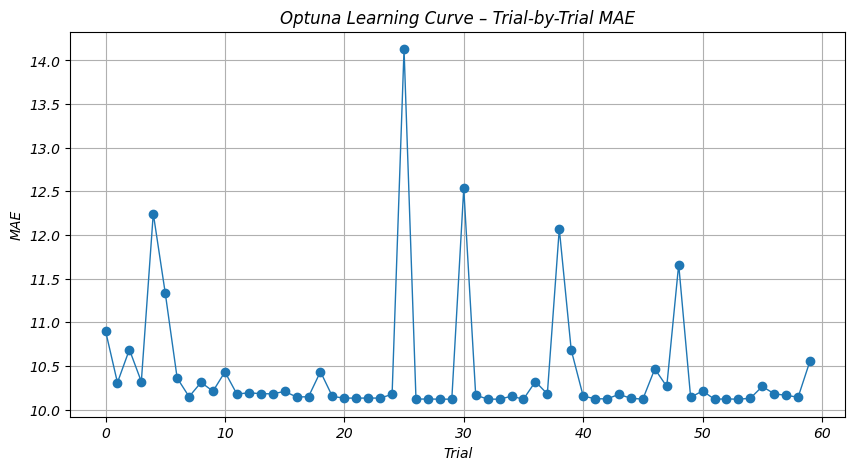

In [10]:
# Tüm trial skorlarını çekelim
trial_numbers = []
trial_mae = []

for t in study.trials:
    if t.value is not None:   # başarısız trial'ları at
        trial_numbers.append(t.number)
        trial_mae.append(t.value)

plt.figure(figsize=(10, 5))
plt.plot(trial_numbers, trial_mae, marker="o", linewidth=1)
plt.xlabel("Trial")
plt.ylabel("MAE")
plt.title("Optuna Learning Curve – Trial-by-Trial MAE")
plt.grid(True)
plt.show()


In [11]:
best_params = study.best_params
best_params

{'n_estimators': 519,
 'max_depth': 9,
 'min_samples_split': 28,
 'min_samples_leaf': 8,
 'max_features': 0.7}

In [12]:
best_rf = RandomForestRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2:", r2_score(y_test, y_pred))

Test MAE: 9.95839742950782
Test RMSE: 15.23036784568897
Test R2: 0.5886746930954685


In [13]:
explainer = shap.TreeExplainer(best_rf)

# Test setini açıklayacağız
shap_values = explainer.shap_values(X_test)

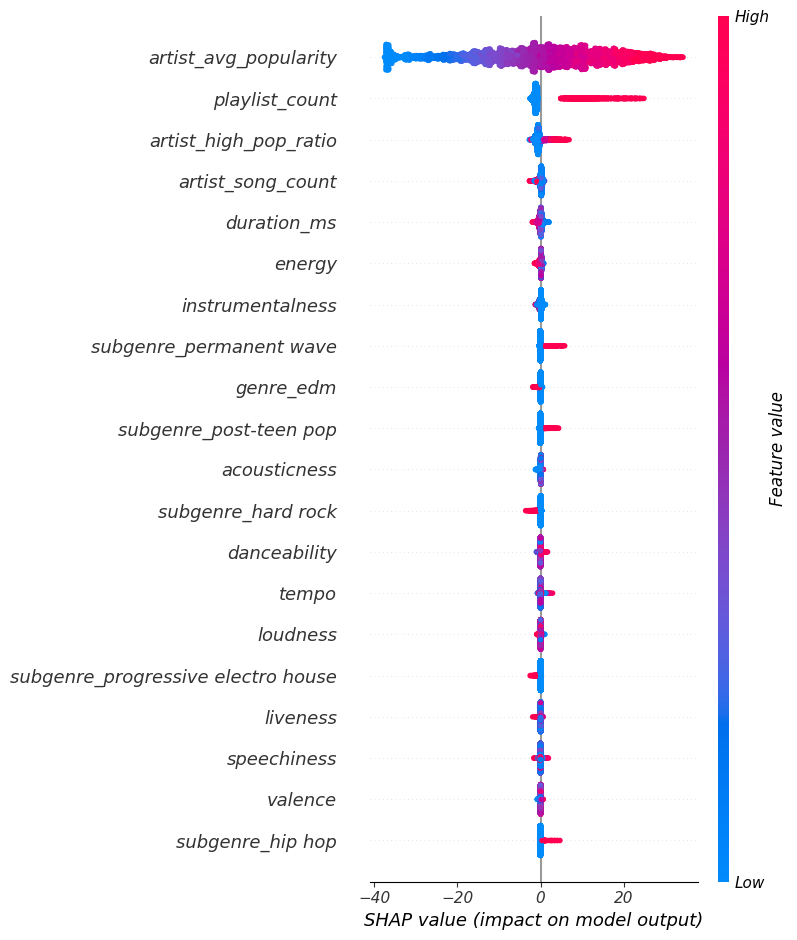

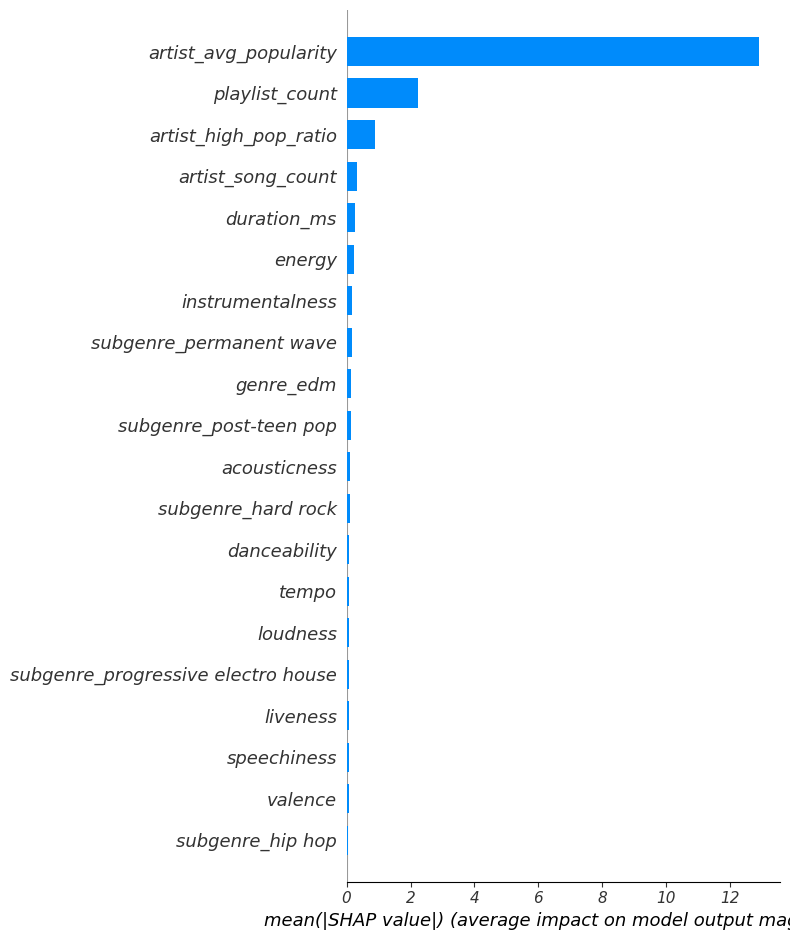

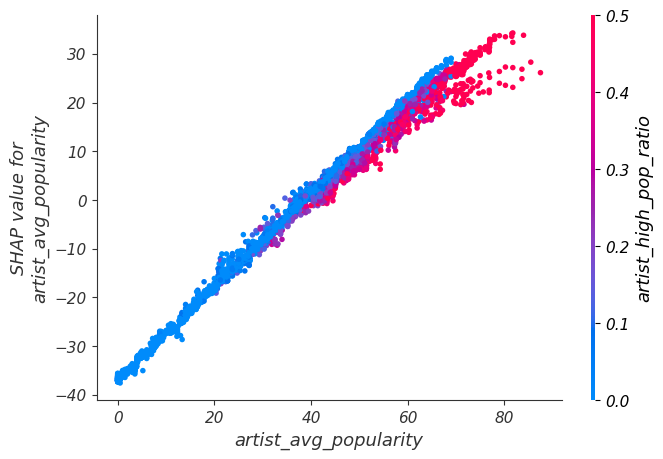

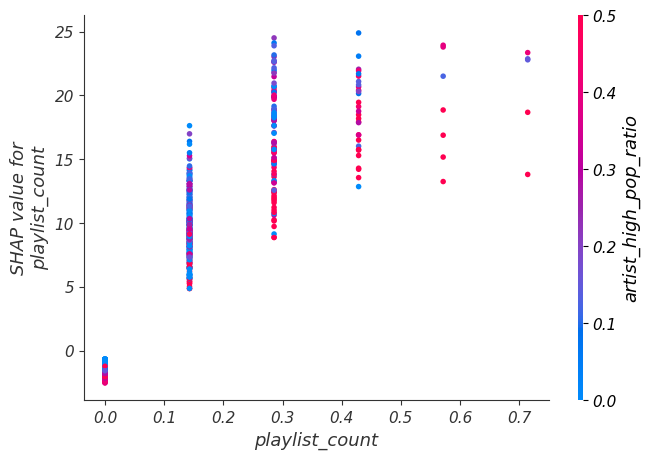

In [14]:
shap.summary_plot(shap_values, X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.dependence_plot("artist_avg_popularity", shap_values, X_test)

shap.dependence_plot("playlist_count", shap_values, X_test)


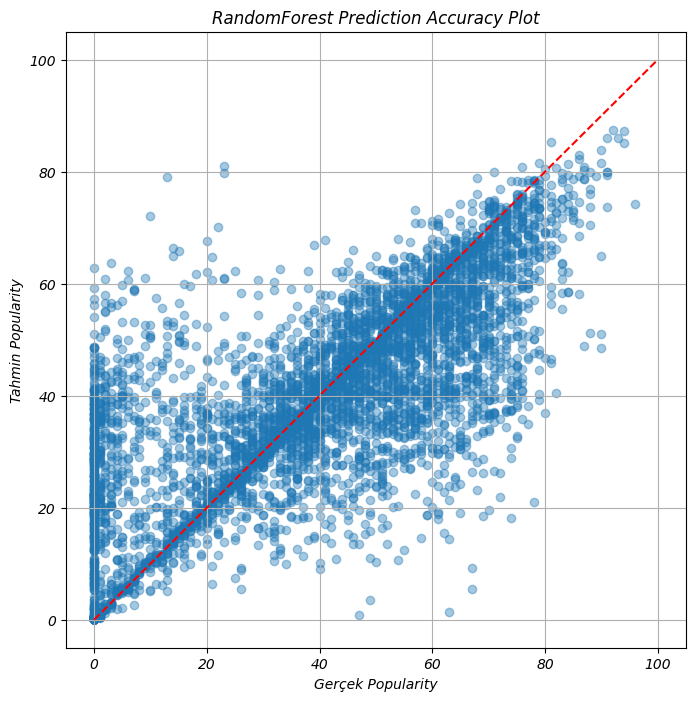

In [15]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel("Gerçek Popularity")
plt.ylabel("Tahmin Popularity")
plt.title("RandomForest Prediction Accuracy Plot")
plt.grid(True)
plt.show()

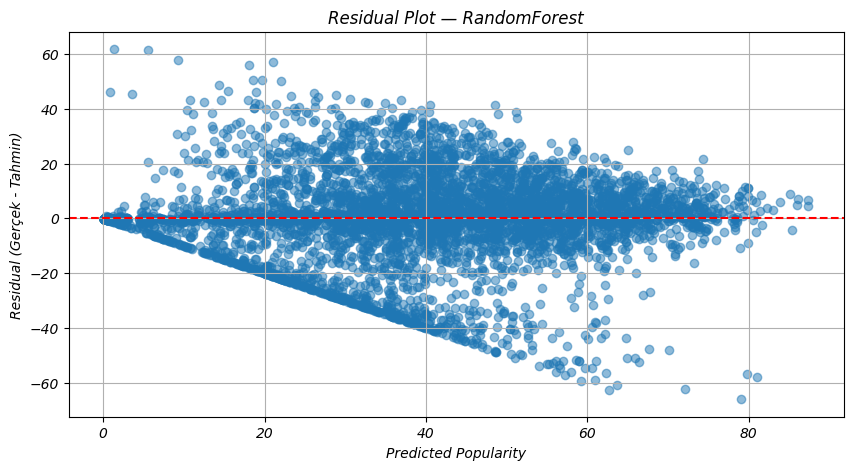

In [16]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Popularity")
plt.ylabel("Residual (Gerçek - Tahmin)")
plt.title("Residual Plot — RandomForest")
plt.grid(True)
plt.show()


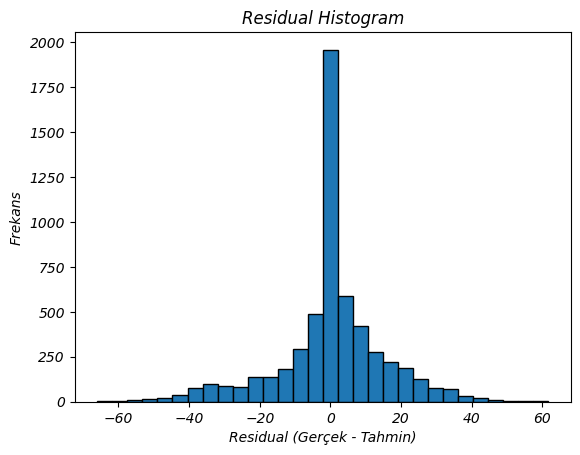

In [17]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residual Histogram")
plt.xlabel("Residual (Gerçek - Tahmin)")
plt.ylabel("Frekans")
plt.show()



>>> Plotting 1D Partial Dependence for: ['artist_avg_popularity', 'playlist_count', 'energy', 'duration_ms']


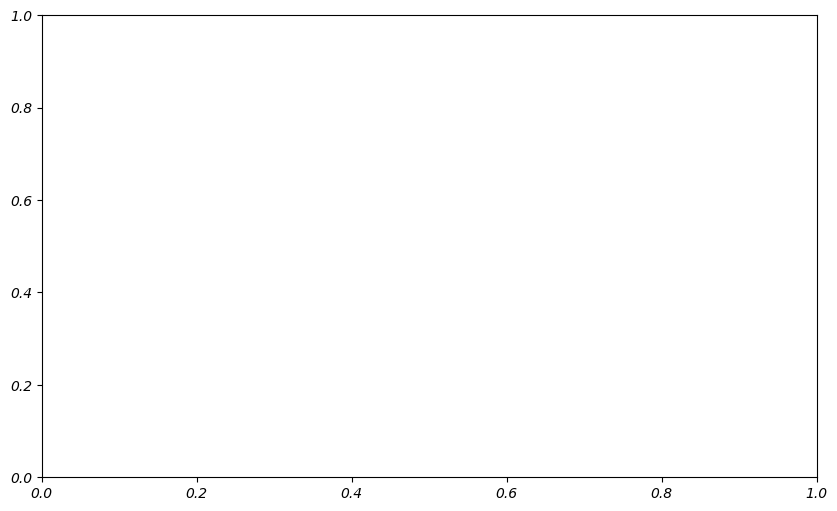

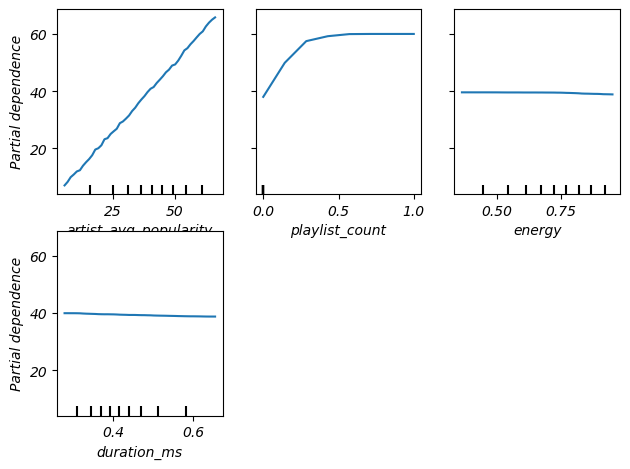

In [18]:

features = ["artist_avg_popularity", "playlist_count", "energy", "duration_ms"]

features_for_pdp = []

for f in ["artist_avg_popularity", "playlist_count", "energy", "duration_ms"]:
    if f in X.columns:
        features_for_pdp.append(f)

if features_for_pdp:
    print("\n>>> Plotting 1D Partial Dependence for:", features_for_pdp)
    fig, ax = plt.subplots(figsize=(10, 6))
    PartialDependenceDisplay.from_estimator(
        best_rf,
        X_train,
        features_for_pdp,
        kind="average",
        grid_resolution=50
    )
    plt.tight_layout()
    plt.show()


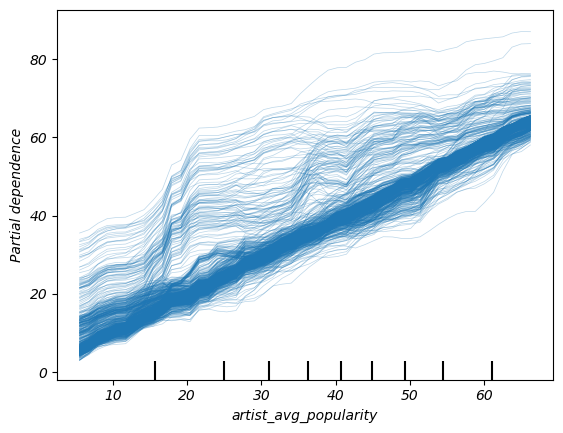

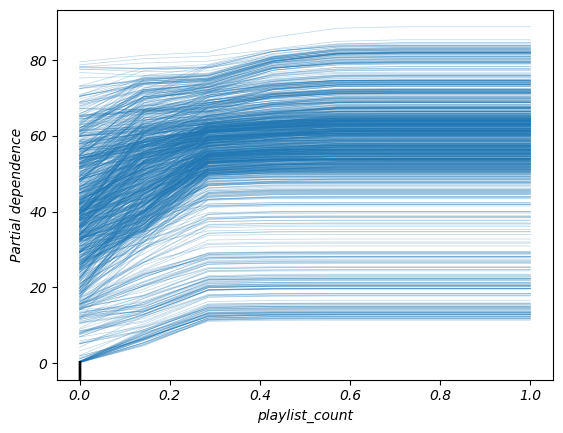

In [20]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    best_rf, X_train, ["artist_avg_popularity"], kind="individual", grid_resolution=50
)
plt.show()

PartialDependenceDisplay.from_estimator(
    best_rf, X_train, ["playlist_count"], kind="individual", grid_resolution=50
)
plt.show()


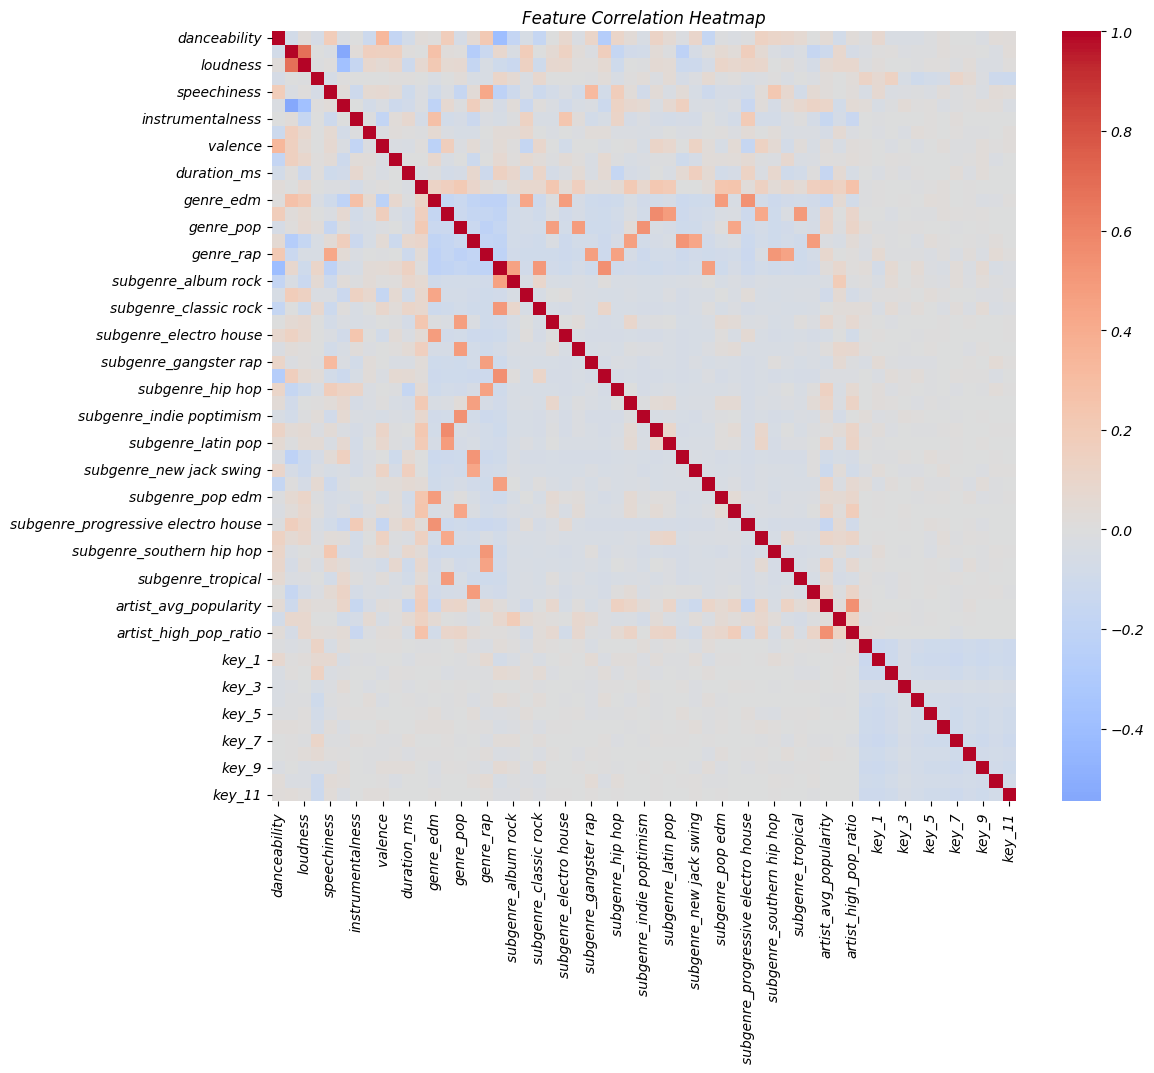

In [21]:
import seaborn as sns
corr = X_train.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
# interaction_values = shap.TreeExplainer(best_rf).shap_interaction_values(X_test)

# shap.summary_plot(interaction_values, X_test)


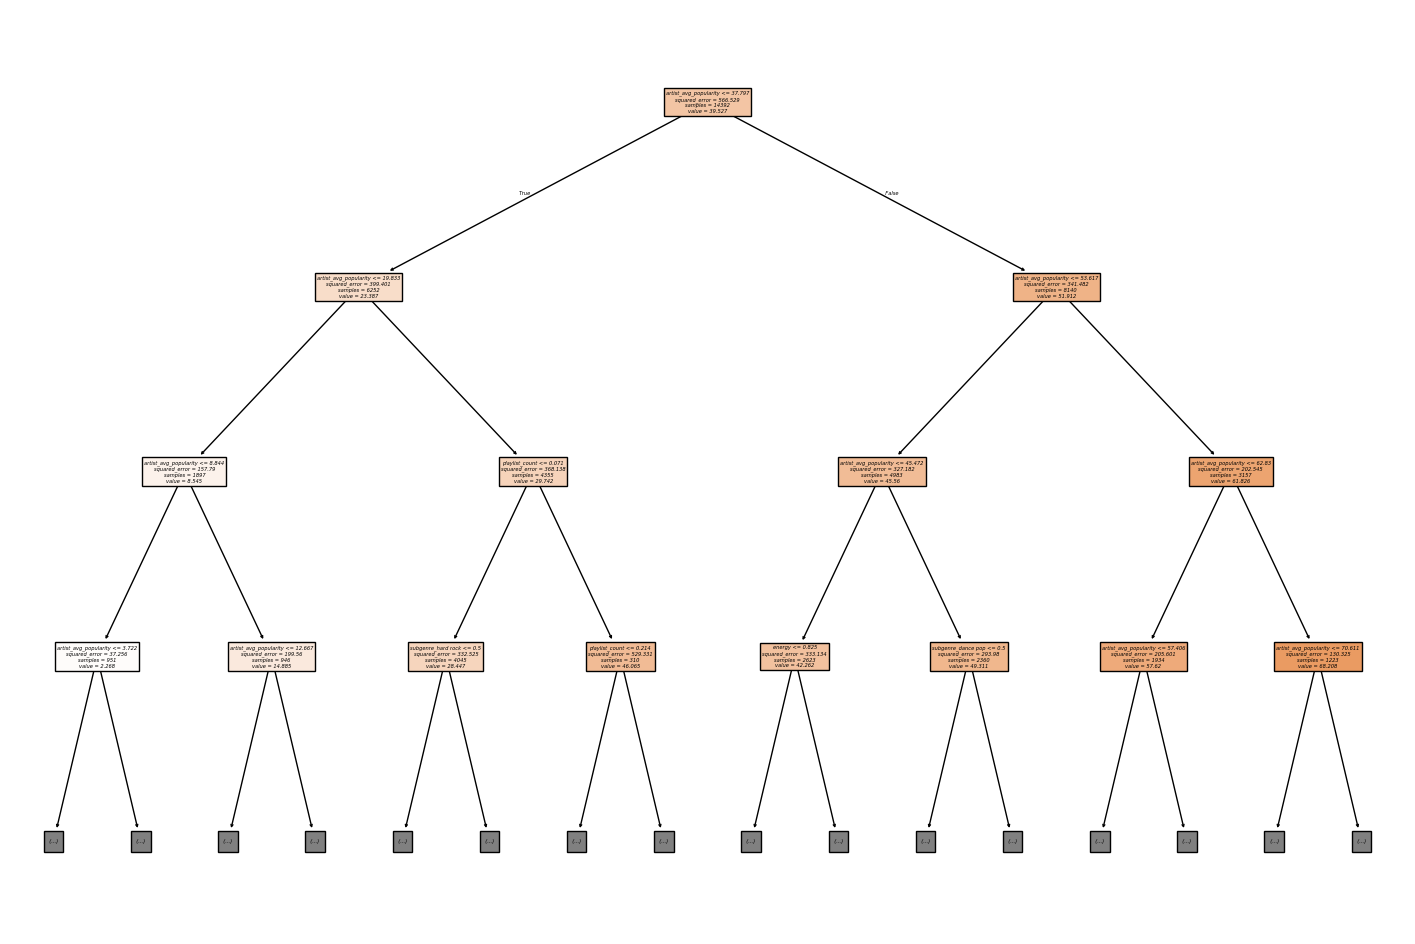

In [22]:
estimator = best_rf.estimators_[0]

from sklearn.tree import plot_tree
plt.figure(figsize=(18, 12))
plot_tree(estimator, feature_names=X_train.columns, filled=True, max_depth=3)
plt.show()


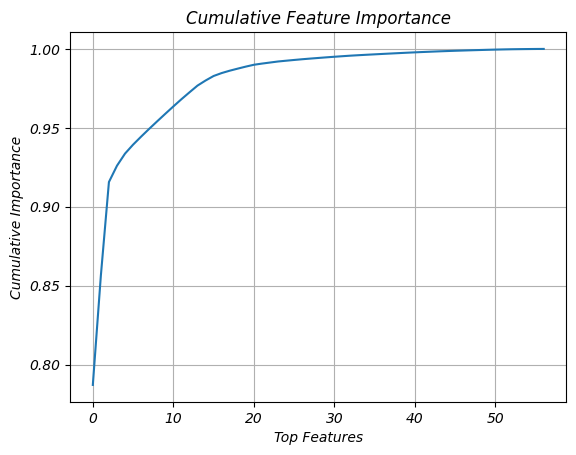

In [23]:
imp = best_rf.feature_importances_
sorted_imp = np.sort(imp)[::-1]
cumulative = np.cumsum(sorted_imp)

plt.plot(cumulative)
plt.xlabel("Top Features")
plt.ylabel("Cumulative Importance")
plt.title("Cumulative Feature Importance")
plt.grid(True)
plt.show()


Top 20 features by importance:
                               feature  importance
42               artist_avg_popularity    0.787066
44               artist_high_pop_ratio    0.069371
11                      playlist_count    0.059208
43                   artist_song_count    0.010335
10                         duration_ms    0.007690
9                                tempo    0.005666
5                         acousticness    0.005095
2                             loudness    0.004928
1                               energy    0.004797
0                         danceability    0.004727
7                             liveness    0.004664
4                          speechiness    0.004561
8                              valence    0.004372
6                     instrumentalness    0.004275
35              subgenre_post-teen pop    0.003219
33             subgenre_permanent wave    0.002866
12                           genre_edm    0.001862
25                  subgenre_hard rock    0.001497

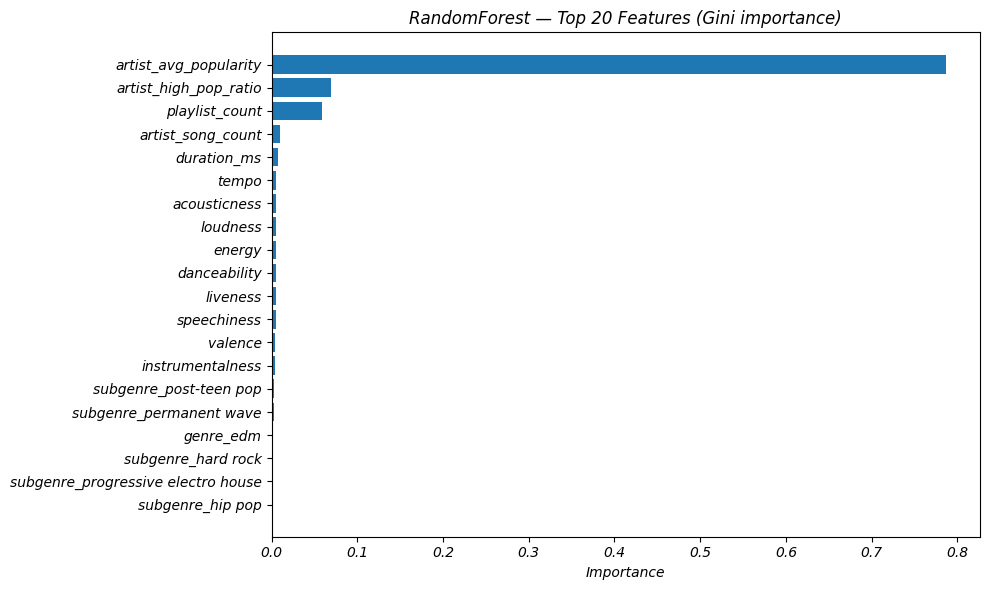

In [24]:
# Feature Importances
importances = best_rf.feature_importances_

feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
})
feature_importance = feature_importance.sort_values("importance", ascending=False)

print("\nTop 20 features by importance:")
print(feature_importance.head(20))

# Bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["feature"].head(20),
         feature_importance["importance"].head(20))
plt.gca().invert_yaxis()
plt.title("RandomForest — Top 20 Features (Gini importance)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()